## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import seaborn as sns

## Preparar os dados

In [2]:
data = np.loadtxt("../data/spiral_d.csv", delimiter=",")
X = data[:, :2].T   # 2 x N
y = data[:, 2]      # N
y = np.where(y==1, 1, -1)

print(data.shape)

(1400, 3)


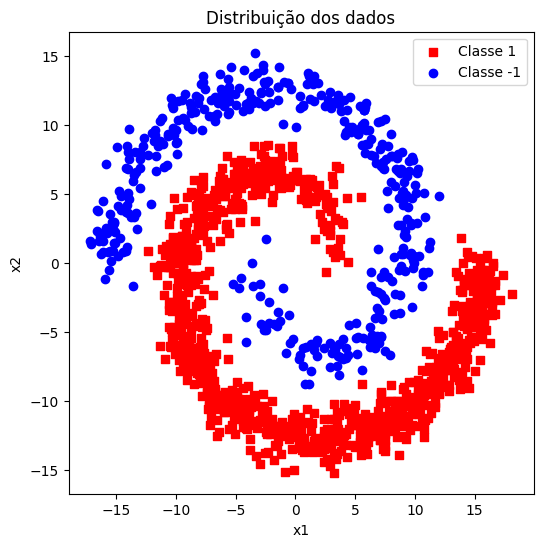

In [3]:
plt.figure(figsize=(6,6))
plt.scatter(X[0, y==1], X[1, y==1], marker='s', color='r', label='Classe 1')
plt.scatter(X[0, y==-1], X[1, y==-1], marker='o', color='b', label='Classe -1')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Distribuição dos dados")
plt.legend()
plt.show()


#### Separando dados

In [4]:
# Particionamento 80% treino, 20% teste
N = X.shape[1]
indices = np.arange(N)
np.random.shuffle(indices)
N_train = int(0.8*N)
train_idx = indices[:N_train]
test_idx  = indices[N_train:]

X_train = X[:, train_idx]
y_train = y[train_idx]

X_test  = X[:, test_idx]
y_test  = y[test_idx]

## Classes

### Funções auxiliares

In [49]:
# Heatmap da matriz de confusão
def show_classification_results(model_name, cm, acc, sensitivity, specificity, precision, f1):
    print(f"{model_name} - Resultados da Classificação:")
    print("\nMatriz de Confusão (formato solicitado):")
    print(cm)
    print(f"\nAcurácia: {acc:.3f}")
    print(f"Sensibilidade (Recall da classe positiva): {sensitivity:.3f}")
    print(f"Especificidade (Recall da classe negativa): {specificity:.3f}")
    print(f"Precisão: {precision:.3f}")
    print(f"F1 Score: {f1:.3f}\n")
    
    # Heatmap da matriz de confusão
    plt.figure(figsize=(5,4))
    
    # MUDANÇA AQUI: Os rótulos de X (xticklabels) foram ajustados
    # para corresponder à sua nova matriz [Prev=1, Prev=-1]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Positivo (1)", "Negativo (-1)"],
                yticklabels=["Positivo (1)", "Negativo (-1)"])
    
    plt.xlabel("Classe Prevista")
    plt.ylabel("Classe Verdadeira")
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.show()

# Matrizes de confusão (manual)
def confusion_matrix_manual(y_true, y_pred):
    """
    Cria a matriz de confusão com base na definição do usuário:
    TP (1, 1)  FP (1, -1)
    TN (-1, 1) FN (-1, -1)
    """
    # Definições Padrão
    TP_std = np.sum((y_true==1) & (y_pred==1))    # Real=1, Prev=1
    FN_std = np.sum((y_true==1) & (y_pred==-1))   # Real=1, Prev=-1
    FP_std = np.sum((y_true==-1) & (y_pred==1))   # Real=-1, Prev=1
    TN_std = np.sum((y_true==-1) & (y_pred==-1))   # Real=-1, Prev=-1
    
    # Mapeando para a estrutura solicitada pelo usuário
    TP = TP_std  # (1, 1)
    FP = FN_std  # (1, -1) -> Este é o Falso Negativo padrão
    TN = FP_std  # (-1, 1) -> Este é o Falso Positivo padrão
    FN = TN_std  # (-1, -1) -> Este é o Verdadeiro Negativo padrão
    
    # Retorna a matriz na estrutura [[TP, FP], [TN, FN]]
    return np.array([[TP, FP],
                     [TN, FN]])

# Métricas
def metrics(cm):
    """
    Calcula métricas a partir da matriz não-padrão:
    cm = [[TP_usr, FP_usr],
          [TN_usr, FN_usr]]
    """
    # Desempacota a matriz do usuário
    TP_usr, FP_usr = cm[0]
    TN_usr, FN_usr = cm[1]
    
    # Mapeia de volta para as definições padrão para cálculo
    TP = TP_usr  # (Real=1, Prev=1)
    FN = FP_usr  # (Real=1, Prev=-1)
    FP = TN_usr  # (Real=-1, Prev=1)
    TN = FN_usr  # (Real=-1, Prev=-1)

    # Calcula métricas usando as fórmulas padrão
    Total = TP + TN + FP + FN
    acc = (TP+TN) / Total if Total != 0 else 0
    sens = TP/(TP+FN) if (TP+FN)!=0 else 0
    spec = TN/(TN+FP) if (TN+FP)!=0 else 0
    prec = TP/(TP+FP) if (TP+FP)!=0 else 0
    f1 = 2*prec*sens/(prec+sens) if (prec+sens)!=0 else 0
    
    return acc, sens, spec, prec, f1

In [59]:
class Perceptron:
    def __init__(self, X_train, y_train, learning_rate=1e-3, plot=True, max_epochs=1000):
        self.p, self.N = X_train.shape
        self.X_train = np.vstack((
            -np.ones((1, self.N)), X_train
        ))
        self.d = y_train
        self.lr = learning_rate
        self.w = np.random.random_sample((self.p+1,1)) - 0.5
        self.plot = plot
        self.max_epochs = max_epochs
        self.x1 = np.linspace(-2, 10)
        
        if plot:
            self.fig = plt.figure(1)
            self.ax = self.fig.add_subplot()
            self.ax.scatter(self.X_train[1, self.d[:]==1],
                            self.X_train[2, self.d[:]==1], marker='s', s=120)
            self.ax.scatter(self.X_train[1, self.d[:]==-1],
                            self.X_train[2, self.d[:]==-1], marker='o', s=120)
            self.ax.set_xlim(-1, 7)
            self.ax.set_ylim(-1, 7)
            self.draw_line()
        
    def draw_line(self, c='k', alpha=1, lw=2):
        x2 = -self.w[1,0]/self.w[2,0]*self.x1 + self.w[0,0]/self.w[2,0]
        x2 = np.nan_to_num(x2)
        if self.plot:
            plt.plot(self.x1, x2, c=c, alpha=alpha, lw=lw)
        
    def activation_function(self, u):
        return 1 if u >= 0 else -1
    
    def fit(self):
        epochs = 0
        error = True
        while error and epochs < self.max_epochs:
            error = False
            for k in range(self.N):
                x_k = self.X_train[:, k].reshape(self.p+1, 1)
                u_k = (self.w.T @ x_k)[0,0]
                y_k = self.activation_function(u_k)
                d_k = self.d[k]
                e_k = d_k - y_k
                if e_k != 0:
                    error = True
                self.w = self.w + self.lr * e_k * x_k
            
            if self.plot:
                plt.pause(.4)
                self.draw_line(c='r', alpha=.5)
            epochs += 1
        
        if self.plot:
            plt.pause(.4)
            self.draw_line(c='g', alpha=1, lw=4)
            plt.show()

        plt.figure(figsize=(6,5))
        plt.scatter(self.X_train[1, self.d[:]==1], self.X_train[2, self.d[:]==1], marker='s', s=120, label='Classe 1')
        plt.scatter(self.X_train[1, self.d[:]==-1], self.X_train[2, self.d[:]==-1], marker='o', s=120, label='Classe -1')
        min_x1 = self.X_train[1, :].min() - 1  # Adiciona uma margem
        max_x1 = self.X_train[1, :].max() + 1  # Adiciona uma margem
        x1 = np.linspace(min_x1, max_x1)
        x2 = -self.w[1,0]/self.w[2,0]*x1 + self.w[0,0]/self.w[2,0]
        x2 = np.nan_to_num(x2)
        plt.plot(x1, x2, c='g', lw=4, label='Linha de decisão final')
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title(f"Perceptron - Última época ({epochs})")
        plt.legend()
        plt.show()
        if epochs == self.max_epochs:
            misclassified = [k for k in range(self.N) 
            if self.activation_function((self.w.T @ self.X_train[:, k].reshape(self.p+1,1))[0,0]) != self.d[k]]
            print(f'Treinamento interrompido após {epochs} épocas (não convergiu completamente).')
            print("Índices dos exemplos incorretos:", misclassified)
            print("Pesos finais:", self.w.ravel())
        else:
            print(f'Treinamento concluído em {epochs} épocas.')

    def predict(self, X):
        N = X.shape[1]
        y_pred = np.zeros(N)
        for i in range(N):
            x_i = np.vstack((-np.ones((1,1)), X[:,i].reshape(-1,1)))
            y_pred[i] = self.activation_function((self.w.T @ x_i)[0,0])
        return y_pred

In [6]:
class MultilayerPerceptron:
    def __init__(self,X_train:np.ndarray, Y_train:np.ndarray, topology:list, learning_rate = 1e-3, max_epoch=10000, tol = 1e-12):
        '''
        X_train (p x N)
        Y_train (C x N) ou (1 x N) se classificação binária
        '''
        self.p , self.N = X_train.shape
        self.m = Y_train.shape[0]
        
        self.X_train = np.vstack((
            -np.ones((1,self.N)),X_train
        ))
        self.tol = tol
        self.lr = learning_rate
        self.d = Y_train
        topology.append(self.m)
        self.W = [None]*len(topology)
        Z = 0
        for i in range(len(self.W)):
            if i == 0:
                W = np.random.random_sample((topology[i],self.p+1))-.5
            else:
                W = np.random.random_sample((topology[i],topology[i-1]+1))-.5
            self.W[i] = W
            Z += W.size
        print(f"Rede MLP com {Z} parâmetros")
        self.max_epoch = max_epoch
        self.y = [None]*len(topology)
        self.u = [None]*len(topology)
        self.delta = [None]*len(topology)
        
    def g(self, u):
        return (1-np.exp(-u))/(1+np.exp(-u))
    
    def g_d(self, u):
        y = self.g(u)
        return .5*(1-y**2)
    
    def backward(self, e,x):
        for i in range(len(self.W)-1,-1,-1):
            if i == len(self.W)-1:
                self.delta[i] = self.g_d(self.u[i]) * e
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            elif i == 0:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@x.T)
                
            else:
                Wnbt = (self.W[i+1][:,1:]).T
                self.delta[i] = self.g_d(self.u[i]) * (Wnbt@self.delta[i+1])
                yb = np.vstack((
                    -np.ones((1,1)),
                    self.y[i-1]
                ))
                self.W[i] = self.W[i] + self.lr*(self.delta[i]@yb.T)
            
    
    def forward(self, x):
        
        for i,W in enumerate(self.W):
            if i == 0:
                self.u[i] = W@x
            else:
                yb = np.vstack((
                    -np.ones((1,1)), self.y[i-1]
                ))
                self.u[i] = W@yb                
            self.y[i] = self.g(self.u[i])
         
        
        
    def EQM(self):
        s = 0
        for k in range(self.N):
            x_k = self.X_train[:,k].reshape(self.p+1,1)
            self.forward(x_k)
            y = self.y[-1]
            d = self.d[:,k].reshape(self.m,1)
            e = d - y
            s += np.sum(e**2)
        return s/(2*self.N)
        
    def fit(self):
        epoch = 0
        EQM1 = 1
        self.history = []
        
        while epoch < self.max_epoch and EQM1>self.tol:
            t1 = time()
            for k in range(self.N):
                x_k = self.X_train[:,k].reshape(self.p+1,1)
                #Forward
                self.forward(x_k)
                y = self.y[-1]
                d = self.d[:,k].reshape(self.m,1)
                e = d - y
                #Backward
                self.backward(e,x_k)
            t2 = time()
            EQM1 = self.EQM()
            self.history.append(EQM1)
            epoch+=1
            print(f"Tempo: {t2-t1:.5f}s  Época: {epoch}, EQM: {EQM1:.15f}")

    def predict(self, X):
        """
        Faz a predição para novos dados X (p x N_test)
        Retorna uma matriz de saída (m x N_test)
        """
        N_test = X.shape[1]

        X_bias = np.vstack((-np.ones((1, N_test)), X))
        
        Y_pred = np.zeros((self.m, N_test))
        
        for k in range(N_test):
            x_k = X_bias[:, k].reshape(self.p+1, 1)
            self.forward(x_k)
            Y_pred[:, k] = self.y[-1][:, 0]
        
        return Y_pred


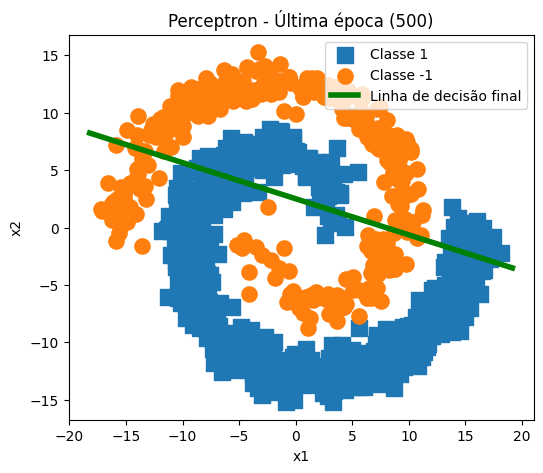

Treinamento interrompido após 500 épocas (não convergiu completamente).
Índices dos exemplos incorretos: [2, 3, 7, 13, 14, 15, 20, 21, 22, 25, 26, 27, 31, 32, 33, 39, 42, 49, 55, 56, 58, 59, 64, 74, 79, 83, 86, 90, 93, 96, 100, 105, 106, 115, 123, 125, 130, 134, 143, 147, 151, 156, 160, 172, 175, 182, 188, 191, 197, 208, 209, 215, 216, 217, 221, 222, 224, 226, 227, 231, 242, 248, 253, 254, 256, 266, 268, 269, 270, 271, 274, 284, 293, 294, 296, 298, 299, 304, 308, 310, 313, 314, 315, 318, 321, 326, 327, 329, 334, 343, 345, 348, 362, 365, 366, 376, 383, 388, 391, 395, 396, 398, 400, 402, 412, 426, 427, 432, 440, 442, 445, 448, 449, 451, 452, 455, 457, 468, 480, 483, 487, 489, 492, 494, 499, 502, 514, 516, 517, 519, 520, 521, 524, 530, 533, 538, 546, 548, 552, 565, 575, 580, 583, 587, 589, 594, 596, 597, 602, 612, 614, 615, 625, 626, 627, 630, 633, 640, 644, 646, 658, 659, 661, 662, 666, 672, 677, 683, 684, 687, 689, 691, 693, 696, 699, 701, 704, 708, 710, 716, 717, 720, 723, 730, 732, 73

In [60]:
perceptron = Perceptron(X_train=X_train, y_train=y_train, learning_rate=0.01, plot=False, max_epochs=500)
perceptron.fit()

Perceptron - Treino - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[646 161]
 [118 195]]

Acurácia: 0.751
Sensibilidade (Recall da classe positiva): 0.800
Especificidade (Recall da classe negativa): 0.623
Precisão: 0.846
F1 Score: 0.822



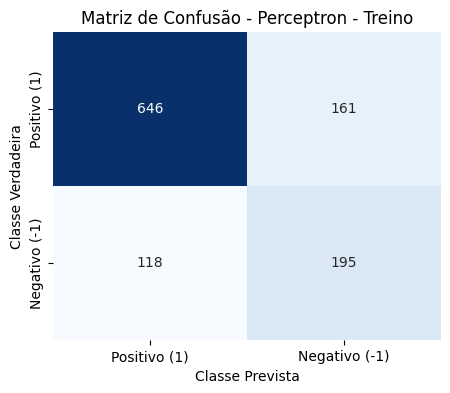

Perceptron - Teste - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[156  37]
 [ 37  50]]

Acurácia: 0.736
Sensibilidade (Recall da classe positiva): 0.808
Especificidade (Recall da classe negativa): 0.575
Precisão: 0.808
F1 Score: 0.808



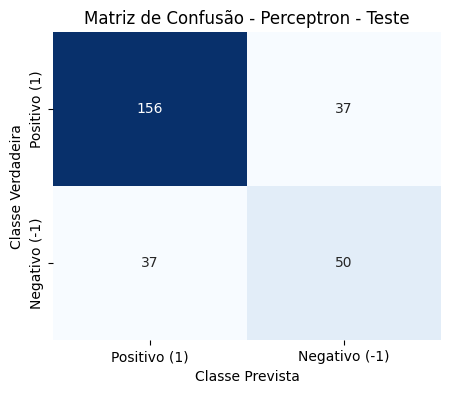

In [58]:
y_pred_train = perceptron.predict(X_train)
y_pred_test  = perceptron.predict(X_test)

cm_train = confusion_matrix_manual(y_train, y_pred_train)
cm_test  = confusion_matrix_manual(y_test, y_pred_test)

acc_train, sens_train, spec_train, prec_train, f1_train = metrics(cm_train)
acc_test, sens_test, spec_test, prec_test, f1_test = metrics(cm_test)

# Matrizes de confusão
cm_train = confusion_matrix_manual(y_train, y_pred_train)
cm_test  = confusion_matrix_manual(y_test, y_pred_test)

# Métricas
acc_train, sens_train, spec_train, prec_train, f1_train = metrics(cm_train)
acc_test, sens_test, spec_test, prec_test, f1_test = metrics(cm_test)

# Exibição dos resultados
show_classification_results("Perceptron - Treino", cm_train, acc_train, sens_train, spec_train, prec_train, f1_train)
show_classification_results("Perceptron - Teste",  cm_test,  acc_test,  sens_test,  spec_test,  prec_test,  f1_test)

In [51]:
# Preparar labels para MLP (1 x N)
Y_train_mlp = y_train.reshape(1, -1)
Y_test_mlp  = y_test.reshape(1, -1)

# Criar MLP (topologia: camada oculta com 5 neurônios)
mlp = MultilayerPerceptron(X_train=X_train, Y_train=Y_train_mlp, topology=[5], learning_rate=0.01, max_epoch=500)
mlp.fit()


Rede MLP com 21 parâmetros
Tempo: 0.07034s  Época: 1, EQM: 0.287293386968385
Tempo: 0.07079s  Época: 2, EQM: 0.273520399987032
Tempo: 0.06957s  Época: 3, EQM: 0.263475018135049
Tempo: 0.07032s  Época: 4, EQM: 0.254338622592734
Tempo: 0.06727s  Época: 5, EQM: 0.244299618735859
Tempo: 0.06659s  Época: 6, EQM: 0.234615035368832
Tempo: 0.06669s  Época: 7, EQM: 0.226255163466477
Tempo: 0.06655s  Época: 8, EQM: 0.218753768461671
Tempo: 0.07732s  Época: 9, EQM: 0.212483297075137
Tempo: 0.07245s  Época: 10, EQM: 0.207351679975366
Tempo: 0.06731s  Época: 11, EQM: 0.203098075910595
Tempo: 0.06564s  Época: 12, EQM: 0.199484613055168
Tempo: 0.06681s  Época: 13, EQM: 0.196324026224361
Tempo: 0.06600s  Época: 14, EQM: 0.193474423181783
Tempo: 0.06816s  Época: 15, EQM: 0.190824122022690
Tempo: 0.06983s  Época: 16, EQM: 0.188277222306239
Tempo: 0.07093s  Época: 17, EQM: 0.185746753210367
Tempo: 0.06737s  Época: 18, EQM: 0.183154984153445
Tempo: 0.07015s  Época: 19, EQM: 0.180436404121937
Tempo: 0.0675

MLP - Treino - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[803   4]
 [ 25 288]]

Acurácia: 0.974
Sensibilidade (Recall da classe positiva): 0.995
Especificidade (Recall da classe negativa): 0.920
Precisão: 0.970
F1 Score: 0.982



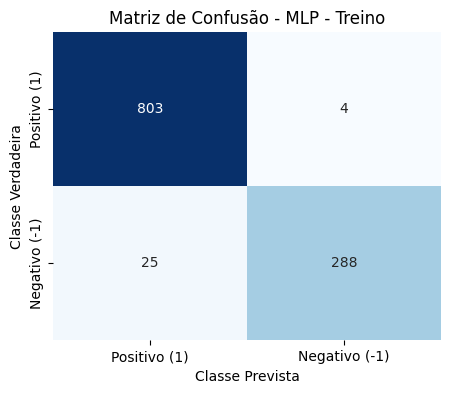

MLP - Teste - Resultados da Classificação:

Matriz de Confusão (formato solicitado):
[[191   2]
 [ 11  76]]

Acurácia: 0.954
Sensibilidade (Recall da classe positiva): 0.990
Especificidade (Recall da classe negativa): 0.874
Precisão: 0.946
F1 Score: 0.967



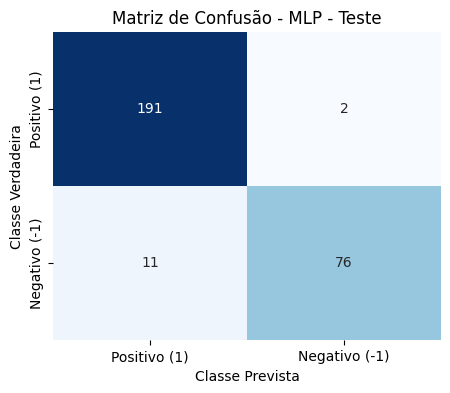

In [52]:
# Predição
Y_pred_train_raw = mlp.predict(X_train)
Y_pred_test_raw  = mlp.predict(X_test)

# Convertendo saída para {-1,1}
y_pred_train_mlp = np.where(Y_pred_train_raw[0,:] >= 0, 1, -1)
y_pred_test_mlp  = np.where(Y_pred_test_raw[0,:] >= 0, 1, -1)

# Matrizes de confusão
cm_train_mlp = confusion_matrix_manual(y_train, y_pred_train_mlp)
cm_test_mlp  = confusion_matrix_manual(y_test, y_pred_test_mlp)

# Métricas
acc_train_mlp, sens_train_mlp, spec_train_mlp, prec_train_mlp, f1_train_mlp = metrics(cm_train_mlp)
acc_test_mlp, sens_test_mlp, spec_test_mlp, prec_test_mlp, f1_test_mlp = metrics(cm_test_mlp)

# Mostrar resultados com heatmap
show_classification_results("MLP - Treino", cm_train_mlp, acc_train_mlp, sens_train_mlp, spec_train_mlp, prec_train_mlp, f1_train_mlp)
show_classification_results("MLP - Teste", cm_test_mlp, acc_test_mlp, sens_test_mlp, spec_test_mlp, prec_test_mlp, f1_test_mlp)

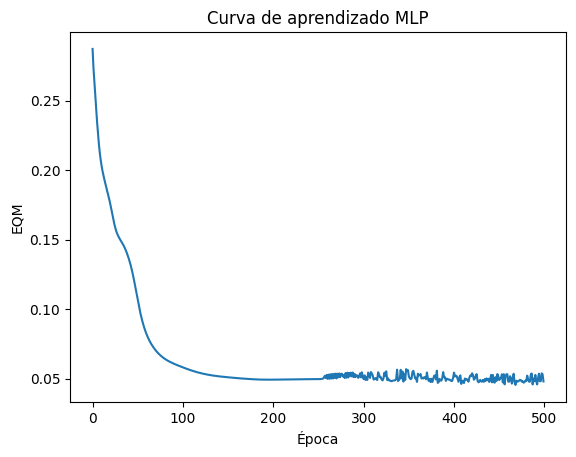

In [63]:
plt.figure()
plt.plot(mlp.history)
plt.xlabel("Época")
plt.ylabel("EQM")
plt.title("Curva de aprendizado MLP")
plt.show()
